In [22]:
%pylab inline
rcParams["figure.figsize"] = (16,5)
from scipy.io import wavfile
import pyworld
import pysptk
import IPython
from IPython.display import Audio
import librosa
import librosa.display

Populating the interactive namespace from numpy and matplotlib


In [23]:
from nnmnkwii.preprocessing import trim_zeros_frames, remove_zeros_frames
import re
from nnmnkwii.io import hts

In [24]:
from glob import glob
import os
import csv

### conduct copy synthesis experiments

**Analysis of speech**

In [25]:
wav_path = "/home/patrick/blizzard_release_2019_v1/wav_16k/100001.wav"
x2, fs = librosa.core.load(wav_path,sr=16000)
x2 = x2.astype(np.float64)
f0, timeaxis = pyworld.harvest(x2, fs, frame_period=5, f0_floor=71.0, f0_ceil=700)
spectrogram = pyworld.cheaptrick(x2, f0, timeaxis, fs)
aperiodicity = pyworld.d4c(x2, f0, timeaxis, fs)

In [10]:
wavfile.write('/home/patrick/100001-copy.wav', 16000, (x2*32678).astype(np.int16))

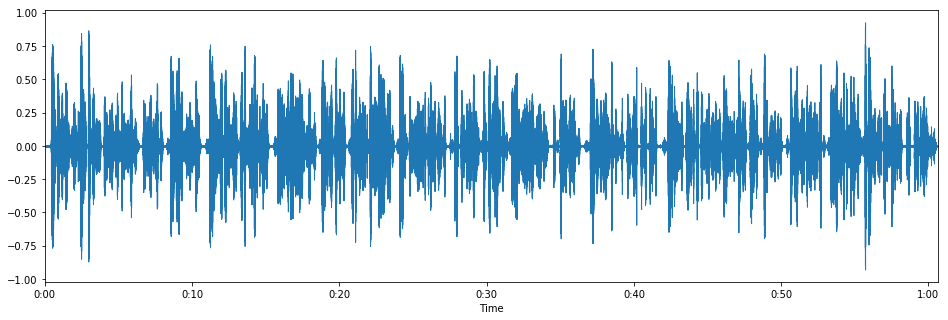

In [26]:
y = pyworld.synthesize(f0, spectrogram, aperiodicity,
                      fs, 5)
librosa.display.waveplot(np.float32(y), sr=fs,max_points=60000)
Audio(y, rate=fs)

**compression spectrum and resynthesis**   
compresse spectrum to 60 dimension and aperiodicty to 1 dimension

In [30]:
alpha=pysptk.util.mcepalpha(16000)
mgc = pysptk.sp2mc(spectrogram, 3, alpha=alpha)
bap = pyworld.code_aperiodicity(aperiodicity, fs)

In [31]:
spectrogram_recover = pysptk.mc2sp(mgc, fftlen=1024, alpha=alpha)
aperiodicity_recover = pyworld.decode_aperiodicity(bap.astype(np.float64), fs, 1024)
generated_waveform = pyworld.synthesize(f0, spectrogram_recover,aperiodicity_recover, fs, 5)

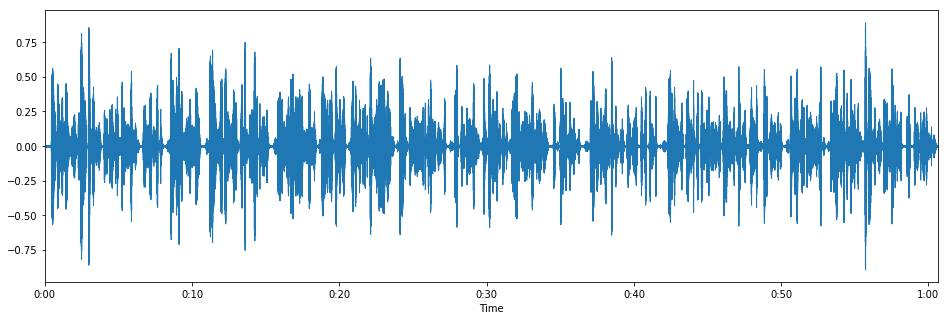

In [32]:
librosa.display.waveplot(np.float32(generated_waveform), sr=fs,max_points=60000)
Audio(generated_waveform, rate=fs)

In [18]:
wavfile.write('/home/patrick/100001-copy-compress.wav', 16000, (generated_waveform*32678).astype(np.int16))

## check correctness of label file(partly)
here we will remove silence of this speech and resynthesis

In [17]:
label_path = "/home/patrick/Documents/label_phone_align/100001.lab"
labels = hts.load(label_path)
silence_indices = labels.silence_frame_indices()
silence_removed_spectrogram = np.delete(spectrogram[:labels.num_frames()], silence_indices, axis=0)
silence_removed_f0 = np.delete(f0[:labels.num_frames()], silence_indices)
silence_removed_aperiodicity = np.delete(aperiodicity[:labels.num_frames()],
                                         silence_indices, axis=0)


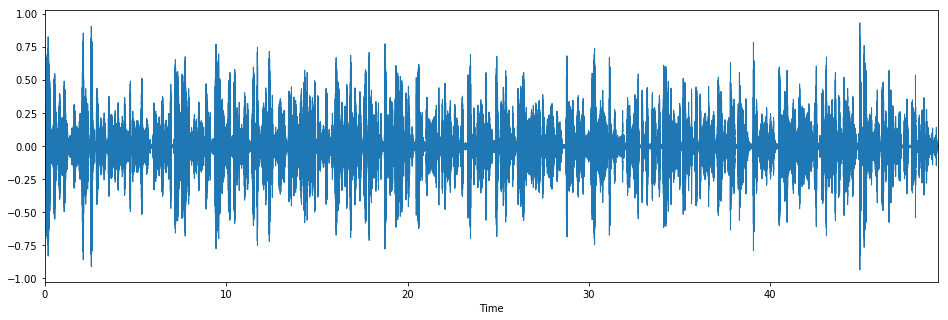

In [20]:
y_remove_silence = pyworld.synthesize(silence_removed_f0, silence_removed_spectrogram, silence_removed_aperiodicity,
                      fs, 5)
librosa.display.waveplot(np.float32(y_remove_silence), sr=fs,max_points=60000)
Audio(y_remove_silence, rate=fs)

In [9]:
def resynthesis(ori_dir, target_dir):
    """
        analysis and resynthesis speech
    """
    for wav_path in glob(ori_dir+"/*.wav"):
        basename=os.path.basename(wav_path)
        fs, x = wavfile.read(wav_path)
        x = x.astype(np.float64)
        f0, timeaxis = pyworld.harvest(x, fs, frame_period=5, f0_floor=71.0, f0_ceil=700)
        spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
        aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)
        # compression
        bap = pyworld.code_aperiodicity(aperiodicity, fs)
        mgc = pysptk.sp2mc(spectrogram, 59, alpha=alpha)
        # f0 modification
        f0_mod=np.zeros(f0.shape)
        non_zeros_indices = np.where(f0!=0)[0]
        f0_mean=np.mean(f0[non_zeros_indices])
        
        # f0 mean
#         f0_mod[non_zeros_indices] = f0_mean
        # f0 increase 
            
        # f0 add noise
#         f0_noise = np.random.rand(len(f0_mod))-0.5
#         f0_mod[non_zeros_indices] = f0[non_zeros_indices]-100*f0_noise[non_zeros_indices]
        # recovery
        # ap_mod
        fake_ap = np.zeros(aperiodicity.shape)
        spectrogram_recover = pysptk.mc2sp(mgc, fftlen=fftlen, alpha=alpha)
        aperiodicity_recover = pyworld.decode_aperiodicity(bap.astype(np.float614), fs, fftlen)
        generated_waveform = pyworld.synthesize(f0, spectrogram_recover,fake_ap, fs, 5)
        generated_waveform = generated_waveform / np.max(np.abs(generated_waveform)) * 32767
        dst_path=os.path.join(target_dir, basename)
        wavfile.write(dst_path, fs, generated_waveform.astype(np.int16))

In [10]:
def analysis(lab_dir, ori_dir,target_dir,csv_file):
    """
        analysis and resynthesis speech
    """
#     csv_fid = open(csv_file,'w')
#     csv_writer = csv.writer(csv_fid)
    story_map = {""}
    for wav_path in glob(ori_dir+"/*.wav"):
        basename=os.path.basename(wav_path)
        utt_id = basename.replace('.wav','')
        print(basename)
        x, fs = librosa.core.load(wav_path,sr=16000)
        x = x.astype(np.float64)
        label_path = os.path.join(lab_dir, basename.replace('wav','lab'))
        print(label_path)
        labels = hts.load(label_path)
        silence_indices = labels.silence_frame_indices()
        f0, timeaxis = pyworld.harvest(x, fs, frame_period=5, f0_floor=71.0, f0_ceil=700)
        spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
        aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)
        silence_removed_spectrogram = np.delete(spectrogram[:labels.num_frames()], silence_indices, axis=0)
        silence_removed_f0 = np.delete(f0[:labels.num_frames()], silence_indices)
        silence_removed_aperiodicity = np.delete(aperiodicity[:labels.num_frames()],
                                         silence_indices, axis=0)    
        mc = pysptk.sp2mc(silence_removed_spectrogram, 39, alpha=alpha)
        bap = pyworld.code_aperiodicity(silence_removed_aperiodicity, fs)
        rmse_en = librosa.feature.rmse(x)
        mean_rmse_en = np.mean(rmse_en)
        var_rmse_en = np.var(rmse_en)
        f0 = f0[:, None]
        nonzero_indices = np.nonzero(f0)
        lf0 = np.log(f0[nonzero_indices])
        lf0_mean = np.mean(lf0)
        lf0_var = np.var(lf0)
        mc_mean = np.mean(mc,axis=0)
        mc_var = np.var(mc,axis=0)
        mc_mean_list = list(mc_mean)
        mc_var_list = list(mc_var)
        csv_row = [utt_id,lf0_mean,lf0_var, mean_rmse_en, var_rmse_en] + mc_mean_list + mc_var_list
        csv_writer.writerow(csv_row)
    csv_fid.close()
#         silence_removed_spectrogram = np.delete(spectrogram[:labels.num_frames()], silence_indices, axis=0)
#         silence_removed_f0 = np.delete(f0[:labels.num_frames()], silence_indices)
#         silence_removed_aperiodicity = np.delete(aperiodicity[:labels.num_frames()],
#                                          silence_indices, axis=0)
#         y = pyworld.synthesize(silence_removed_f0, silence_removed_spectrogram, silence_removed_aperiodicity,
#                       fs, 5)
#         dst_path=os.path.join(target_dir, basename)
#         librosa.output.write_wav(dst_path,y,sr=fs)

In [ ]:
def enery_statis(lab_dir, ori_dir,target_dir,csv_file):
    """
        analysis and resynthesis speech
    """
#     csv_fid = open(csv_file,'w')
#     csv_writer = csv.writer(csv_fid)
    story_map = {"s100":0, "s101":1,"s102":2,"s103":3,"s104":4,"s26":5,"s27":6,"s29":7,"s30":8,"s31":9,"s57":10,"s58":11,"s59":12,"s105":13}
    for s_key in story_map.keys():
        story_aver_
        for wav_path in glob(ori_dir+"/*.wav"):
            basename=os.path.basename(wav_path)
            utt_id = basename.replace('.wav','')
            s_index = re.split('_',utt_id)[0]
            if s_key != s_index:
                continue
            x, fs = librosa.core.load(wav_path,sr=16000)
            x = x.astype(np.float64)
            label_path = os.path.join(lab_dir, basename.replace('wav','lab'))
            labels = hts.load(label_path)
            silence_indices = labels.silence_frame_indices()
            rmse_en = librosa.feature.rmse(x)
        

In [378]:
story_map = {"s100":0, "s101":1,"s102":2,"s103":3,"s104":4,"s26":5,"s27":6,"s29":7,"s30":8,"s31":9,"s57":10,"s58":11,"s59":12,"s105":13}
for s_key in story_map.keys():
    total_duration = 0
    total_utterance = 0
    for wav_path in glob(ori_dir+"/*.wav"):
        basename=os.path.basename(wav_path)
        utt_id = basename.replace('.wav','')
        s_index = re.split('_',utt_id)[0]
        if s_key != s_index:
            continue
        x, fs = librosa.core.load(wav_path,sr=16000)
        total_duration += size(x)//16000
        total_utterance +=1
    print("story index {0}, total duration {1}, total utterance {2}".format(s_key, total_duration, total_utterance))

story index s100, total duration 324, total utterance 59
story index s101, total duration 427, total utterance 66
story index s102, total duration 487, total utterance 68
story index s103, total duration 328, total utterance 49
story index s104, total duration 571, total utterance 112
story index s26, total duration 288, total utterance 42
story index s27, total duration 438, total utterance 68
story index s29, total duration 459, total utterance 75
story index s30, total duration 413, total utterance 53
story index s31, total duration 229, total utterance 37
story index s57, total duration 312, total utterance 37
story index s58, total duration 159, total utterance 20
story index s59, total duration 212, total utterance 24
story index s105, total duration 294, total utterance 50


In [302]:
lab_dir="/home/patrick/corpous/name_clean3/label_phone_align"
ori_dir="/home/patrick/corpous/name_clean3"
target_dir="/home/patrick/corpous/name_clean3/s100/remove_silence"
csv_file="/home/patrick/corpous/name_clean3/stats.csv"
analysis(lab_dir, ori_dir,target_dir,csv_file)

s102_24.wav
/home/patrick/corpous/name_clean3/label_phone_align/s102_24.lab
s31_out_20a.wav
/home/patrick/corpous/name_clean3/label_phone_align/s31_out_20a.lab
s27_out_4b.wav
/home/patrick/corpous/name_clean3/label_phone_align/s27_out_4b.lab
s104_73.wav
/home/patrick/corpous/name_clean3/label_phone_align/s104_73.lab
s104_93.wav
/home/patrick/corpous/name_clean3/label_phone_align/s104_93.lab
s30_out_10.wav
/home/patrick/corpous/name_clean3/label_phone_align/s30_out_10.lab
s100_19.wav
/home/patrick/corpous/name_clean3/label_phone_align/s100_19.lab
s101_20.wav
/home/patrick/corpous/name_clean3/label_phone_align/s101_20.lab
s102_16.wav
/home/patrick/corpous/name_clean3/label_phone_align/s102_16.lab
s104_27.wav
/home/patrick/corpous/name_clean3/label_phone_align/s104_27.lab
s58_out_7.wav
/home/patrick/corpous/name_clean3/label_phone_align/s58_out_7.lab
s102_28.wav
/home/patrick/corpous/name_clean3/label_phone_align/s102_28.lab
s101_28a.wav
/home/patrick/corpous/name_clean3/label_phone_align

s29_out_49b.wav
/home/patrick/corpous/name_clean3/label_phone_align/s29_out_49b.lab
s58_out_3.wav
/home/patrick/corpous/name_clean3/label_phone_align/s58_out_3.lab
s105_29.wav
/home/patrick/corpous/name_clean3/label_phone_align/s105_29.lab
s101_18.wav
/home/patrick/corpous/name_clean3/label_phone_align/s101_18.lab
s104_87.wav
/home/patrick/corpous/name_clean3/label_phone_align/s104_87.lab
s57_out_20.wav
/home/patrick/corpous/name_clean3/label_phone_align/s57_out_20.lab
s58_out_15.wav
/home/patrick/corpous/name_clean3/label_phone_align/s58_out_15.lab
s27_out_23a.wav
/home/patrick/corpous/name_clean3/label_phone_align/s27_out_23a.lab
s29_out_43.wav
/home/patrick/corpous/name_clean3/label_phone_align/s29_out_43.lab
s27_out_45a.wav
/home/patrick/corpous/name_clean3/label_phone_align/s27_out_45a.lab
s59_out_13b.wav
/home/patrick/corpous/name_clean3/label_phone_align/s59_out_13b.lab
s101_35.wav
/home/patrick/corpous/name_clean3/label_phone_align/s101_35.lab
s59_out_15a.wav
/home/patrick/corp

s105_2.wav
/home/patrick/corpous/name_clean3/label_phone_align/s105_2.lab
s58_out_4.wav
/home/patrick/corpous/name_clean3/label_phone_align/s58_out_4.lab
s30_out_26.wav
/home/patrick/corpous/name_clean3/label_phone_align/s30_out_26.lab
s104_107.wav
/home/patrick/corpous/name_clean3/label_phone_align/s104_107.lab
s27_out_23b.wav
/home/patrick/corpous/name_clean3/label_phone_align/s27_out_23b.lab
s26_out_30a.wav
/home/patrick/corpous/name_clean3/label_phone_align/s26_out_30a.lab
s27_out_34a.wav
/home/patrick/corpous/name_clean3/label_phone_align/s27_out_34a.lab
s100_38.wav
/home/patrick/corpous/name_clean3/label_phone_align/s100_38.lab
s104_7.wav
/home/patrick/corpous/name_clean3/label_phone_align/s104_7.lab
s30_out_40a.wav
/home/patrick/corpous/name_clean3/label_phone_align/s30_out_40a.lab
s102_45.wav
/home/patrick/corpous/name_clean3/label_phone_align/s102_45.lab
s101_4.wav
/home/patrick/corpous/name_clean3/label_phone_align/s101_4.lab
s104_5.wav
/home/patrick/corpous/name_clean3/label

s29_out_42.wav
/home/patrick/corpous/name_clean3/label_phone_align/s29_out_42.lab
s29_out_4b.wav
/home/patrick/corpous/name_clean3/label_phone_align/s29_out_4b.lab
s101_46.wav
/home/patrick/corpous/name_clean3/label_phone_align/s101_46.lab
s104_106.wav
/home/patrick/corpous/name_clean3/label_phone_align/s104_106.lab
s104_63.wav
/home/patrick/corpous/name_clean3/label_phone_align/s104_63.lab
s26_out_6.wav
/home/patrick/corpous/name_clean3/label_phone_align/s26_out_6.lab
s103_6.wav
/home/patrick/corpous/name_clean3/label_phone_align/s103_6.lab
s104_21.wav
/home/patrick/corpous/name_clean3/label_phone_align/s104_21.lab
s103_2.wav
/home/patrick/corpous/name_clean3/label_phone_align/s103_2.lab
s102_25.wav
/home/patrick/corpous/name_clean3/label_phone_align/s102_25.lab
s103_7.wav
/home/patrick/corpous/name_clean3/label_phone_align/s103_7.lab
s30_out_6.wav
/home/patrick/corpous/name_clean3/label_phone_align/s30_out_6.lab
s100_4.wav
/home/patrick/corpous/name_clean3/label_phone_align/s100_4.la

s101_39a.wav
/home/patrick/corpous/name_clean3/label_phone_align/s101_39a.lab
s29_out_46.wav
/home/patrick/corpous/name_clean3/label_phone_align/s29_out_46.lab
s57_out_0.wav
/home/patrick/corpous/name_clean3/label_phone_align/s57_out_0.lab
s103_14.wav
/home/patrick/corpous/name_clean3/label_phone_align/s103_14.lab
s101_26.wav
/home/patrick/corpous/name_clean3/label_phone_align/s101_26.lab
s100_3.wav
/home/patrick/corpous/name_clean3/label_phone_align/s100_3.lab
s58_out_6.wav
/home/patrick/corpous/name_clean3/label_phone_align/s58_out_6.lab
s100_10a.wav
/home/patrick/corpous/name_clean3/label_phone_align/s100_10a.lab
s104_99.wav
/home/patrick/corpous/name_clean3/label_phone_align/s104_99.lab
s29_out_37.wav
/home/patrick/corpous/name_clean3/label_phone_align/s29_out_37.lab
s59_out_8.wav
/home/patrick/corpous/name_clean3/label_phone_align/s59_out_8.lab
s27_out_45b.wav
/home/patrick/corpous/name_clean3/label_phone_align/s27_out_45b.lab
s102_9.wav
/home/patrick/corpous/name_clean3/label_pho

s29_out_27.wav
/home/patrick/corpous/name_clean3/label_phone_align/s29_out_27.lab
s26_out_26.wav
/home/patrick/corpous/name_clean3/label_phone_align/s26_out_26.lab
s57_out_4.wav
/home/patrick/corpous/name_clean3/label_phone_align/s57_out_4.lab
s58_out_14b.wav
/home/patrick/corpous/name_clean3/label_phone_align/s58_out_14b.lab
s101_36b.wav
/home/patrick/corpous/name_clean3/label_phone_align/s101_36b.lab
s105_38.wav
/home/patrick/corpous/name_clean3/label_phone_align/s105_38.lab
s29_out_47b.wav
/home/patrick/corpous/name_clean3/label_phone_align/s29_out_47b.lab
s101_1b.wav
/home/patrick/corpous/name_clean3/label_phone_align/s101_1b.lab
s104_16.wav
/home/patrick/corpous/name_clean3/label_phone_align/s104_16.lab
s104_35.wav
/home/patrick/corpous/name_clean3/label_phone_align/s104_35.lab
s105_45.wav
/home/patrick/corpous/name_clean3/label_phone_align/s105_45.lab
s29_out_55.wav
/home/patrick/corpous/name_clean3/label_phone_align/s29_out_55.lab
s26_out_4b.wav
/home/patrick/corpous/name_clean3

s29_out_33a.wav
/home/patrick/corpous/name_clean3/label_phone_align/s29_out_33a.lab
s29_out_18a.wav
/home/patrick/corpous/name_clean3/label_phone_align/s29_out_18a.lab
s103_27.wav
/home/patrick/corpous/name_clean3/label_phone_align/s103_27.lab
s103_17.wav
/home/patrick/corpous/name_clean3/label_phone_align/s103_17.lab
s29_out_41.wav
/home/patrick/corpous/name_clean3/label_phone_align/s29_out_41.lab
s29_out_2b.wav
/home/patrick/corpous/name_clean3/label_phone_align/s29_out_2b.lab
s27_out_19.wav
/home/patrick/corpous/name_clean3/label_phone_align/s27_out_19.lab
s31_out_21b.wav
/home/patrick/corpous/name_clean3/label_phone_align/s31_out_21b.lab
s105_41.wav
/home/patrick/corpous/name_clean3/label_phone_align/s105_41.lab
s31_out_15.wav
/home/patrick/corpous/name_clean3/label_phone_align/s31_out_15.lab
s30_out_40b.wav
/home/patrick/corpous/name_clean3/label_phone_align/s30_out_40b.lab
s102_19.wav
/home/patrick/corpous/name_clean3/label_phone_align/s102_19.lab
s104_102.wav
/home/patrick/corpo

s103_44.wav
/home/patrick/corpous/name_clean3/label_phone_align/s103_44.lab
s29_out_36.wav
/home/patrick/corpous/name_clean3/label_phone_align/s29_out_36.lab
s101_22a.wav
/home/patrick/corpous/name_clean3/label_phone_align/s101_22a.lab
s30_out_34b.wav
/home/patrick/corpous/name_clean3/label_phone_align/s30_out_34b.lab
s102_58.wav
/home/patrick/corpous/name_clean3/label_phone_align/s102_58.lab
s29_out_1.wav
/home/patrick/corpous/name_clean3/label_phone_align/s29_out_1.lab
s101_47b.wav
/home/patrick/corpous/name_clean3/label_phone_align/s101_47b.lab
s103_18.wav
/home/patrick/corpous/name_clean3/label_phone_align/s103_18.lab
s103_19.wav
/home/patrick/corpous/name_clean3/label_phone_align/s103_19.lab
s27_out_28a.wav
/home/patrick/corpous/name_clean3/label_phone_align/s27_out_28a.lab
s29_out_0.wav
/home/patrick/corpous/name_clean3/label_phone_align/s29_out_0.lab
s27_out_31.wav
/home/patrick/corpous/name_clean3/label_phone_align/s27_out_31.lab
s102_47.wav
/home/patrick/corpous/name_clean3/la

In [337]:
story_map = {"s100":0, "s101":1,"s102":2,"s103":3,"s104":4,"s26":5,"s27":6,"s29":7,"s30":8,"s31":9,"s57":10,"s58":11,"s59":12,"s105":13}

In [348]:
y = []
X = []
with open(csv_file,'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        s_index = re.split('_',row[0])[0]
        s_num = story_map[s_index]
        row_data = []
        for sdata in row[1:]:
            row_data.append(float(sdata))
        y.append(s_num)
        X.append(row_data)

In [354]:
from sklearn.feature_selection import SelectKBest

In [355]:
from sklearn.feature_selection import chi2

In [363]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

In [364]:
clf = ExtraTreesClassifier(n_estimators=50)
model = SelectFromModel(clf, prefit=True)

In [369]:
clf = clf.fit(X[:,0:4], y)

In [370]:
clf.feature_importances_

array([ 0.19786889,  0.23969402,  0.28439214,  0.27804495])

In [356]:
y=np.array(y)

In [358]:
X.shape

(760, 84)

In [359]:
model1 = SelectKBest(chi2, k=2)

In [361]:
model1.fit_transform(X[:,0:4],y)

array([[ 0.08488326,  0.04916909],
       [ 0.07060433,  0.0653136 ],
       [ 0.0322313 ,  0.02685207],
       ..., 
       [ 0.09566944,  0.03691672],
       [ 0.06558673,  0.08833791],
       [ 0.09796428,  0.04605107]])

In [362]:
model1.pvalues_

array([ 1.        ,  0.94139061,  0.98556614,  0.99999075])

In [175]:

label_path = "/home/patrick/corpous/name_clean3/label_phone_align/s100_0.lab"
labels = hts.load(label_path)
silence_indices = labels.silence_frame_indices()
x2, fs = librosa.core.load(wav_path,sr=16000)
x2 = x2.astype(np.float64)

In [269]:
x3 = 3*x2+0.1

In [270]:
f0_x3, timeaxis = pyworld.harvest(x3, fs, frame_period=5, f0_floor=71.0, f0_ceil=700)
spectrogram_x3 = pyworld.cheaptrick(x3, f0, timeaxis, fs)
aperiodicity_x3 = pyworld.d4c(x3, f0, timeaxis, fs)

In [287]:
mc = pysptk.sp2mc(spectrogram, 60, alpha=alpha)
bap = pyworld.code_aperiodicity(aperiodicity, fs)
spectrogram_recover = pysptk.mc2sp(mc, fftlen=1024, alpha=alpha)
aperiodicity_recover = pyworld.decode_aperiodicity(bap.astype(np.float64), fs, 1024)

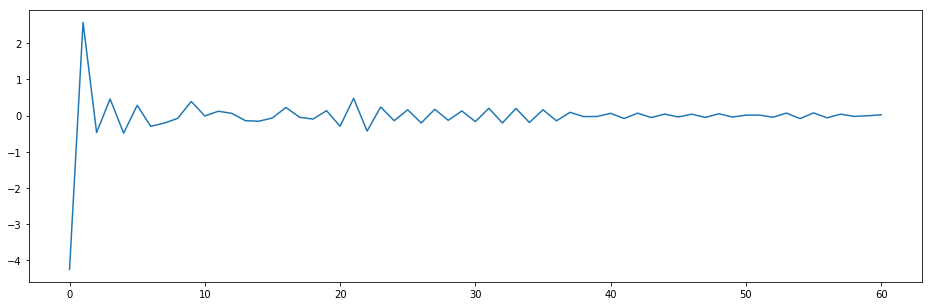

In [291]:
plot(mc[112,:])

In [181]:
silence_removed_spectrogram = np.delete(spectrogram[:labels.num_frames()], silence_indices, axis=0)
silence_removed_f0 = np.delete(f0[:labels.num_frames()], silence_indices)
silence_removed_aperiodicity = np.delete(aperiodicity[:labels.num_frames()],
                                         silence_indices, axis=0)

In [224]:
mc_mean=np.mean(mc,axis=0)

In [247]:
mc_mean.shape

(30,)

In [221]:
mc_var=np.var(mc,axis=0)

In [218]:
mc_cov = np.cov(np.transpose(mc))

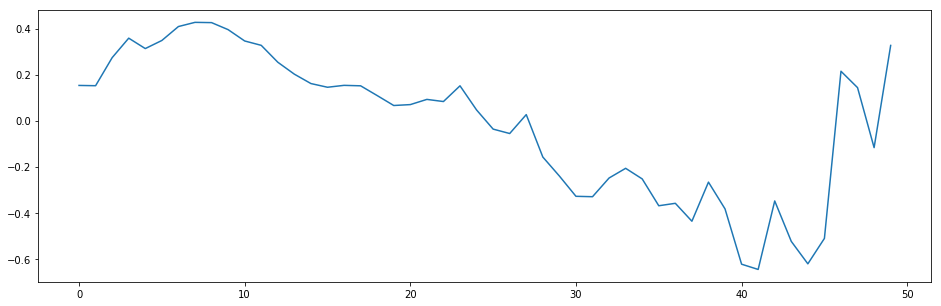

In [229]:
plot(mc[100:150,7])

In [200]:
mc.shape

(1318, 30)

In [204]:
mc_mean = np.mean(mc,axis=0)

In [205]:
mc_mean.shape

(30,)

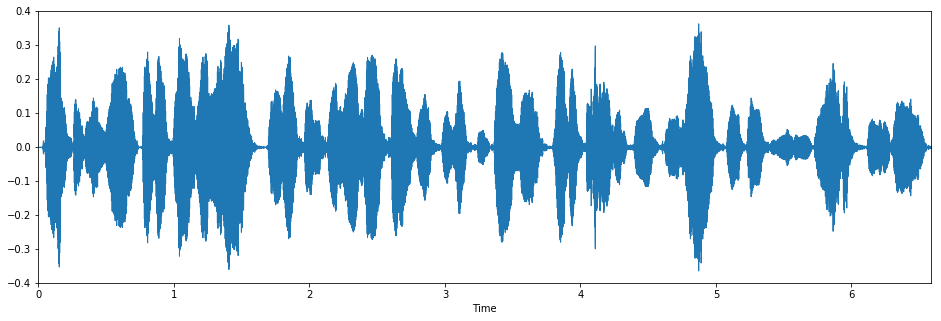

In [242]:
y = pyworld.synthesize(silence_removed_f0, spectrogram_recover, aperiodicity_recover,
                      fs, 5)
librosa.display.waveplot(np.float32(y), sr=fs)
Audio(y, rate=fs)

In [92]:
rmse_x_lib=librosa.feature.rmse(x,n_fft=343,hop_length=80)

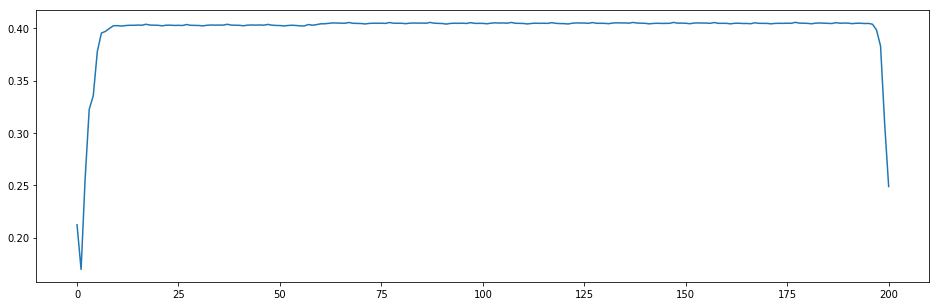

In [98]:
plot(rmse_x_lib[0,:])

In [111]:
rmse_x_lib=librosa.feature.rmse(generated_waveform,n_fft=343,hop_length=80)

In [52]:
spectrogram.shape

(201, 513)

In [53]:
librosa_sp = librosa.core.stft(x_lib, n_fft=1024, hop_length=80, win_length=343)

In [55]:
librosa_sp = np.transpose(librosa_sp)

In [58]:
mag_librosa_sp = np.abs(librosa_sp)

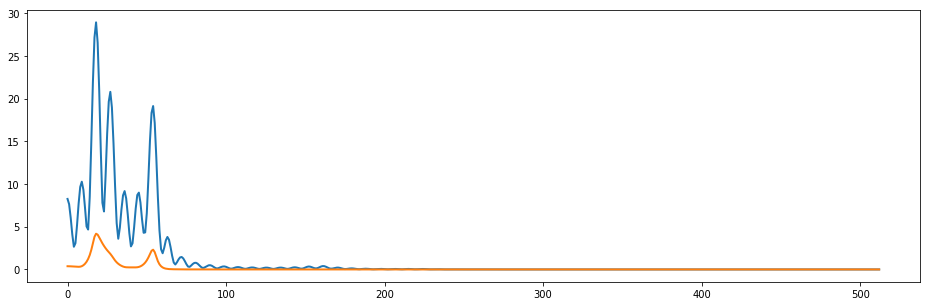

In [63]:
plot(mag_librosa_sp[101,:],linewidth=2)
plot(spectrogram[101,:],linewidth=2)

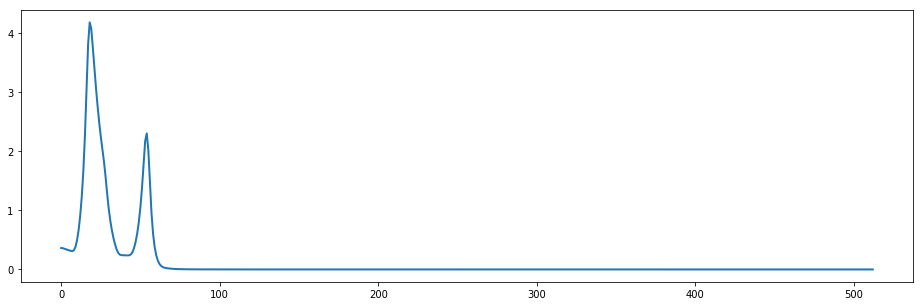

In [61]:
plot(spectrogram[100,:],linewidth=2)

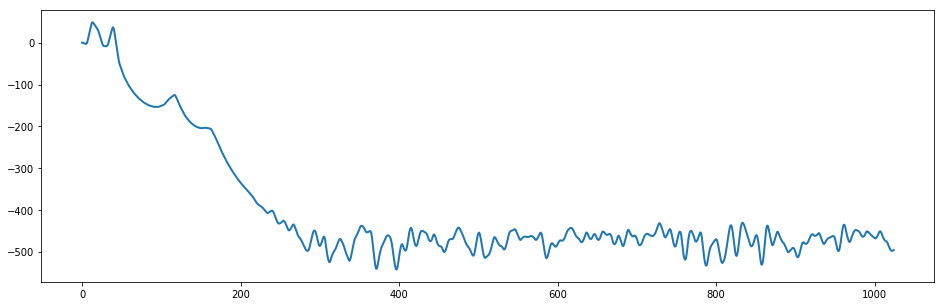

In [20]:
plot(20*np.log(spectrogram[114,:]),linewidth=2)

In [28]:
generated_waveform = pyworld.synthesize(f0, spectrogram,aperiodicity, fs, 5)

In [30]:
generated_waveform

array([-0.01045088, -0.01048836, -0.01052587, ..., -0.01755288,
       -0.01874817, -0.01969721])

In [203]:
spectrogram_recover = pysptk.mc2sp(mgc, fftlen=fftlen, alpha=alpha)
bap = pyworld.code_aperiodicity(aperiodicity, fs)

In [205]:
aperiodicity_recover = pyworld.decode_aperiodicity(bap.astype(np.float64), fs, fftlen)

In [206]:
generated_waveform = pyworld.synthesize(f0, spectrogram,aperiodicity, fs, 5)

In [207]:
non_zeros_indices = np.where(f0!=0)[0]

In [270]:
f0_mod[non_zeros_indices] = f0[non_zeros_indices]-100*f0_noise[non_zeros_indices]

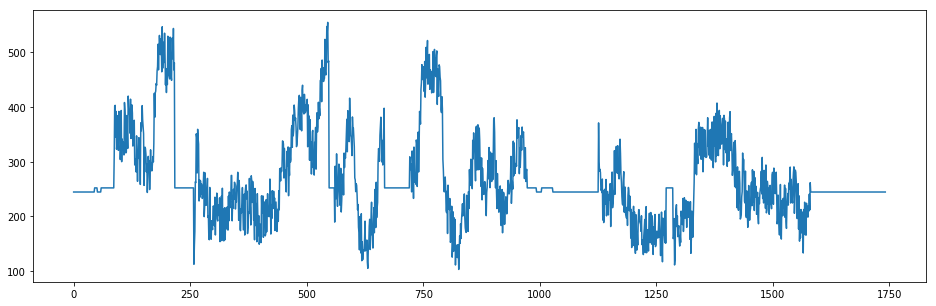

In [271]:
plot(f0_modd)

In [211]:
f0_mean=np.mean(f0[non_zeros_indices])

In [220]:
f0_mod[non_zeros_indices] = f0_mean

In [221]:
generated_waveform_mod = pyworld.synthesize(f0_mod, spectrogram,aperiodicity, fs, 5)

In [222]:
Audio(generated_waveform_mod, rate=fs)

In [161]:
Audio(generated_waveform, rate=fs)